## Detecting Plant Disease

Welcome to my notebook. Throughout this notebook, I will load in the necesarry libraries and the PlantVillage dataset. The PlantVillage dataset includes images of several leaves of 38 different types of crops. 

I will iterate over several models to make predictions for healthy and diseased plants. 

### Loading in the data

Load in the necessary libraries. 

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,Activation,LeakyReLU,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, LSTM, AveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from timeit import default_timer as timer
from pathlib import Path
import imagesize
from PIL import Image

Setting some defaults to add into models easier

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../1Capstone1/PlantVillage-Dataset/raw/'
width=256
height=256
depth=3

Function to convert images to an array to feed into a model. 

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Loading in the images and their classes. 

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


In [ ]:
image_size = len(image_list)
image_size

### EDA

In [ ]:
#Remember this is only for the color photos, repeat this step for the grayscale and segmented photos 
root = '../1Capstone1/PlantVillage-Dataset/raw/color/'

In [ ]:
def images_to_df(root):
    """ Returns a concatenated DataFrame containing columns for FileName, Size, Width, Aspect Ratio, and Image Type.
    Some of this code was taken from https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05 that grabs the Width and Height of the images. 
    
    root1: first path to image folder.
    root2: second path to image folder. 
    image_type1: Image Type from the first folder.
    image_type2: Image Type from the second folder.
    
    """ 
    imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".JPG"]
    img_meta = {}
    for f in imgs: img_meta[str(f)] = imagesize.get(root+f)

    # Convert it to Dataframe and compute aspect ratio
    data = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
    data[["Width", "Height"]] = pd.DataFrame(data["Size"].tolist(), index=data.index)
    data["Aspect Ratio"] = round(data["Width"] / data["Height"], 2)
    
    return data

In [ ]:
all_roots = []
for x in plant_disease_folder_list:     
        all_roots.append(f'{root}{x}/')

all_roots

In [ ]:
healthy_images = []
for x in all_roots: 
    if x[-8:] == 'healthy/': 
        healthy_images.append(x)
healthy_images

In [ ]:
len(healthy_images)

In [ ]:
num_list = []
for x in range(len(all_roots)): 
    num_list.append(x)
root_dict = dict(zip(num_list, all_roots))

root_dict[6][-8:]

all_roots[6][-8:]

In [ ]:
total_img_list = []
for q in range(38):
    for img in Path(all_roots[q]).iterdir(): 
        if img.suffix == ".JPG": 
            total_img_list.append(f'{img}')
total_img_list[370]

In [ ]:
image_sizes = []
for s in range(len(total_img_list)):
    im = Image.open(total_img_list[s])
    image_sizes.append(im.size)

image_sizes

In [ ]:
data1 = pd.DataFrame(image_sizes, columns=('Width', 'Height'))

In [ ]:
names_list = []
for q in range(38):
    for img in Path(all_roots[q]).iterdir(): 
        if img.suffix == ".JPG": 
            names_list.append(f'{img}')
names_list[0]

In [ ]:
data1['FileName'] = names_list

data1['Bool'] = data1['FileName'].str.contains('healthy')
data1['Bool'] = data1['Bool'].astype('object')
data1['Bool'].replace(True, 'Healthy', inplace=True)
data1['Bool'].replace(False, 'Disease', inplace=True)
data1['Type'] = data1['Bool']

Get labels from the images

In [23]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [24]:
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [25]:
start = timer()

np_image_list = np.array(image_list, dtype=np.float16) / 225.0

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Total Time Elapsed:  2  minutes  44  seconds


In [26]:
print("[INFO] Spliting data to train, test")
X_train, X_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [27]:
print(len(X_train))
print(len(X_test))

18124
4532


### First Simple Model

In [28]:
model = Sequential()
inputShape = (height, width, depth)

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 231200)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              236749824 
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0

In [29]:
aug = ImageDataGenerator(
    rotation_range=50, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    )

In [30]:
model.compile(loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
start = timer()

history = model.fit(
          aug.flow(X_train, y_train),
          validation_data=(X_test, y_test),
          steps_per_epoch=20,
          epochs=10, 
          verbose=1, 
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [ ]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

### Second Model

In [ ]:
model_2 = Sequential()
inputShape = (height, width, depth)

model_2.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(1024))
model_2.add(Activation("relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(n_classes))
model_2.add(Activation("softmax"))

model_2.summary()

In [ ]:
model_2.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
aug = ImageDataGenerator(
      rotation_range=25, 
      width_shift_range=0.1,
      height_shift_range=0.1, 
      shear_range=0.2, 
      zoom_range=0.2, 
      horizontal_flip=True 
    )

In [ ]:
start = timer()

history_2 = model_2.fit(
            aug.flow(X_train, y_train),
            validation_data=(X_test, y_test),
            steps_per_epoch=100,
            epochs=10, 
            verbose=1, 
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

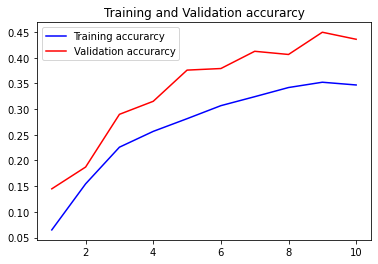

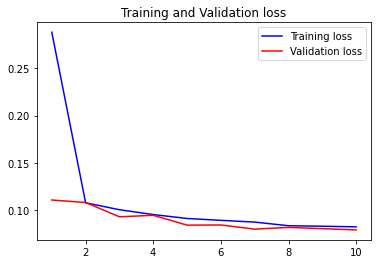

[INFO] Calculating model accuracy
142/142 [==============================] - 26s 182ms/step - loss: 0.0789 - accuracy: 0.4358
Test Accuracy: 43.578994274139404


In [20]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

### Third Model

In [21]:
model_3 = Sequential()
inputShape = (height, width, depth)

model_3.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(3, 3)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding="same"))
model_3.add(Activation("relu"))

model_3.add(Conv2D(64, (3, 3), padding="same"))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3, 3), padding="same"))
model_3.add(Activation("relu"))

model_3.add(Conv2D(128, (3, 3), padding="same"))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(1024))
model_3.add(Activation("relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(n_classes))
model_3.add(Activation("softmax"))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 85, 85, 64)       

In [22]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2, vertical_flip=True 
    )

In [23]:
model_3.compile(loss="categorical_crossentropy",metrics=["accuracy"])

In [24]:
start = timer()

history_3 = model_3.fit(
          aug.flow(X_train, y_train, batch_size=BS),
          validation_data=(X_test, y_test),
          steps_per_epoch=len(X_train) // BS,
          epochs=15, 
          verbose=1
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/15
566/566 [==============================] - 839s 1s/step - loss: 3.4241 - accuracy: 0.0994 - val_loss: 3.3824 - val_accuracy: 0.1379
Epoch 2/15
566/566 [==============================] - 845s 1s/step - loss: 2.4334 - accuracy: 0.3043 - val_loss: 1.7305 - val_accuracy: 0.4771
Epoch 3/15
566/566 [==============================] - 818s 1s/step - loss: 1.8823 - accuracy: 0.4355 - val_loss: 1.4164 - val_accuracy: 0.5675
Epoch 4/15
566/566 [==============================] - 827s 1s/step - loss: 1.6005 - accuracy: 0.5158 - val_loss: 1.2343 - val_accuracy: 0.6355
Epoch 5/15
566/566 [==============================] - 815s 1s/step - loss: 1.4150 - accuracy: 0.5710 - val_loss: 1.0495 - val_accuracy: 0.6873
Epoch 6/15
566/566 [==============================] - 805s 1s/step - loss: 1.2932 - accuracy: 0.6112 - val_loss: 1.3141 - val_accuracy: 0.6542
Epoch 7/15
566/566 [==============================] - 827s 1s/step - loss: 1.2073 - accuracy: 0.6365 - val_loss: 1.3605 - val_accuracy: 0.6443

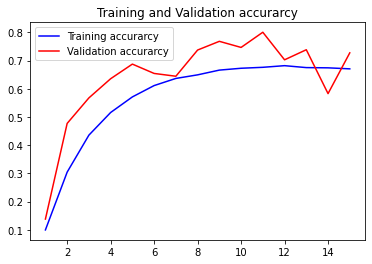

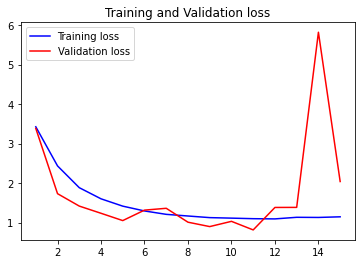

[INFO] Calculating model accuracy
142/142 [==============================] - 39s 272ms/step - loss: 2.0384 - accuracy: 0.7273
Test Accuracy: 72.72727489471436


In [25]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model_3.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

### Fourth Model

In [29]:
model_4 = Sequential()
inputShape = (height, width, depth)

model_4.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(3, 3)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(64, (3, 3), padding="same"))
model_4.add(Activation("relu"))

model_4.add(Conv2D(64, (3, 3), padding="same"))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(128, (3, 3), padding="same"))
model_4.add(Activation("relu"))

model_4.add(Conv2D(128, (3, 3), padding="same"))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(256, (3, 3), padding="same"))
model_4.add(Activation("relu"))

model_4.add(Conv2D(256, (3, 3), padding="same"))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Flatten())
model_4.add(Dense(1024))
model_4.add(Activation("relu"))
model_4.add(Dropout(0.5))
model_4.add(Dense(n_classes))
model_4.add(Activation("softmax"))

model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_3 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 64)       

In [30]:
model_4.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
start = timer()

history_4 = model_4.fit(
          aug.flow(X_train, y_train, batch_size=BS),
          validation_data=(X_test, y_test),
          steps_per_epoch=len(X_train) // BS,
          epochs=EPOCHS, 
          verbose=1
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/25
 22/566 [>.............................] - ETA: 13:58 - loss: 0.1421 - accuracy: 0.0270

KeyboardInterrupt: 

In [ ]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model_4.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

### Predictions

In [28]:
def predict_disease(image_path, estimator):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = estimator.predict_classes(np_image)
    print((label_binarizer.classes_[result][0]))

Apple___Cedar_apple_rust


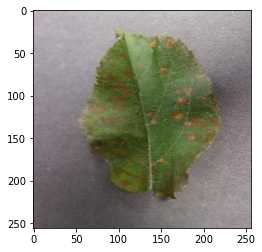

In [30]:
path = '../1Capstone1/PlantVillage-Dataset/raw/color/Apple___Cedar_apple_rust/0340baaa-e9cc-4c04-8f9b-c204180d9ae3___FREC_C.Rust 3805.JPG'
predict_disease(path, model_4)

Blueberry___healthy


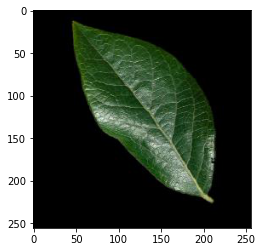

In [33]:
path = '../1Capstone1/PlantVillage-Dataset/raw/segmented/Blueberry___healthy/011405e4-a92a-44b6-9f04-10fec28d93f5___RS_HL 2311_final_masked.jpg'
predict_disease(path, model_4)